# Local Field Potentials (LFPs)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data files you want to analyze

#### Put the .abf files with your recordings in the "data/LFPs" folder

In [2]:
data_folder = "data/8-LFPs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/8-LFPs


['data/8-LFPs/picro_100uA.abf',
 'data/8-LFPs/no_picro_50uA.abf',
 'data/8-LFPs/no_picro_200uA.abf',
 'data/8-LFPs/50uA.abf',
 'data/8-LFPs/100uA.abf',
 'data/8-LFPs/no_picro_100uA.abf',
 'data/8-LFPs/picro_50uA.abf',
 'data/8-LFPs/picro_200uA.abf',
 'data/8-LFPs/200uA.abf',
 'data/8-LFPs/250uA.abf',
 'data/8-LFPs/picro_250uA.abf',
 'data/8-LFPs/no_picro_150uA.abf',
 'data/8-LFPs/150uA.abf',
 'data/8-LFPs/no_picro_250uA.abf',
 'data/8-LFPs/picro_150uA.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

You will also need to enter the stimulus currents you used for each recording, since they are not recorded by your acquisition setup

In [ ]:
data_files = ['data/8-LFPs/no_picro_50uA.abf',
            'data/8-LFPs/no_picro_100uA.abf',
            'data/8-LFPs/no_picro_150uA.abf',
            'data/8-LFPs/no_picro_200uA.abf',
            'data/8-LFPs/no_picro_250uA.abf']

# data_files = ['data/8-LFPs/picro_50uA.abf',
#             'data/8-LFPs/picro_100uA.abf',
#             'data/8-LFPs/picro_150uA.abf',
#             'data/8-LFPs/picro_200uA.abf',
#             'data/8-LFPs/picro_250uA.abf']

stim_amplitudes = [50,100,150,200,250]

Let's start by loading just one file and plot the raw data:

Trace('no_picro_250uA.abf')
Number of sweeps: 20
Points per sweep: 8,000
Duration per sweep: 0.800 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


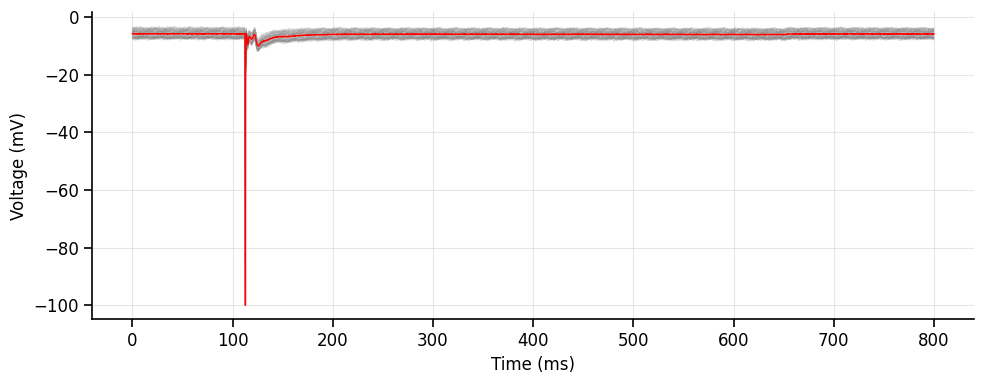

In [4]:
data_file = data_files[-1]

traces = Trace.from_axon_file(filename=data_file, 
                              recording_mode="I clamp",
                              load_ttl=False,
                              units=['pA','mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_current=False, plot_voltage=True, sweep='all', time_units=time_units, plot_mean=True, height_ratios=(1,3))
# ax1.set_ylim(-30,-20)
plt.show()

Now let's average the sweeps for each recording (stimulation current) and combine them into a single object

Trace('data/8-LFPs/no_picro_250uA.abf')
Number of sweeps: 5
Points per sweep: 8,000
Duration per sweep: 0.800 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage, TTL


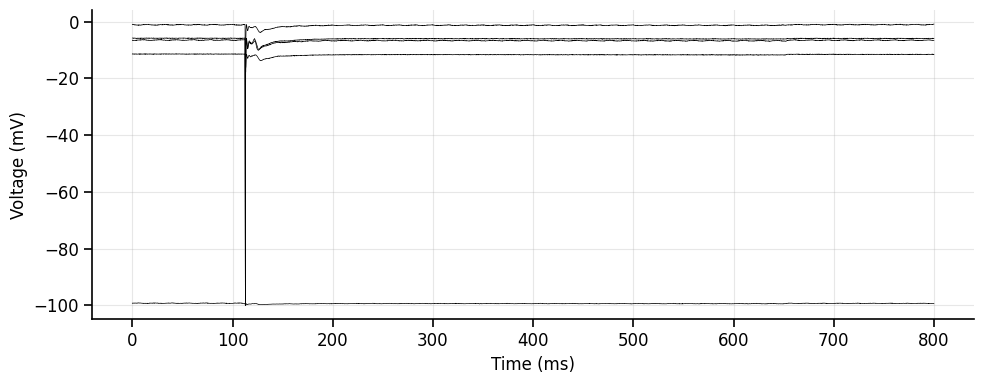

In [5]:
traces = combine_traces_across_files(data_files,  average_across_sweeps=True, recording_mode="current clamp")
print(traces)

# ----------------------------------------------------------------------------------------------------------------
traces.plot(plot_voltage=True, plot_current=False, sweep='all', time_units=time_units)
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline voltages (mV): [-99.2554 -11.4066  -1.1277  -6.4991  -5.8217]


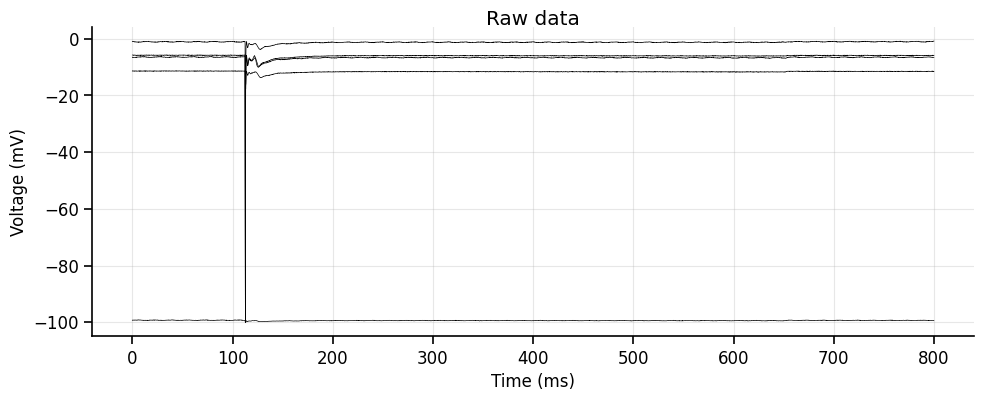

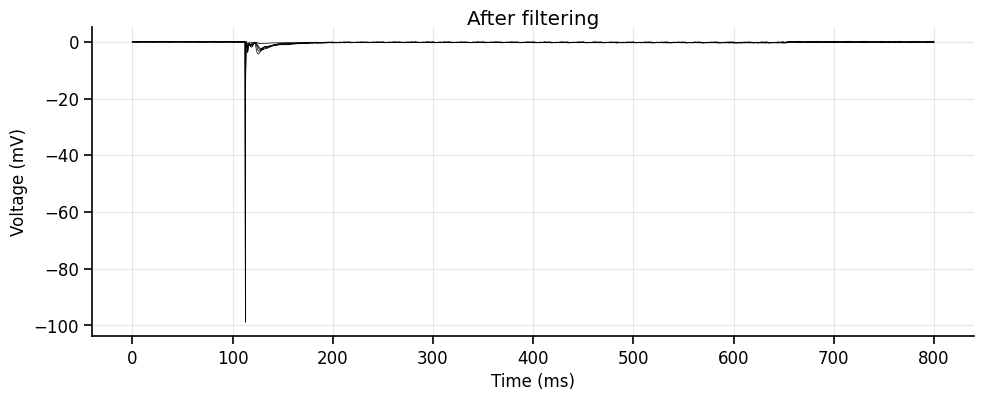

In [6]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False  # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1, apply_to_voltage=True)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 2000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = 0  # Start time for baseline subtraction
    end_baseline = 10  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'voltage')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')
    ax.set_title('After filtering', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [7]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the fiber volley amplitude

In [8]:
# Choose setting to automatically detect the stimulus artifact (capacitive transient)
# stim_times = traces.get_event_times(threshold=-20, 
#                                     polarity='negative', 
#                                     time_units=time_units, 
#                                     channel='voltage', sweep=0)
stim_times = traces.get_step_events(threshold=1, channel='ttl', edge = 'rising', 
                        polarity = 'positive', time_units=time_units, sweep=0)
print(f"Stim times: {stim_times} ms")


Stim times: [112.5] ms


First we will define the time window in which to measure the peak of the fiber volley (the first peak after the stim artifact)

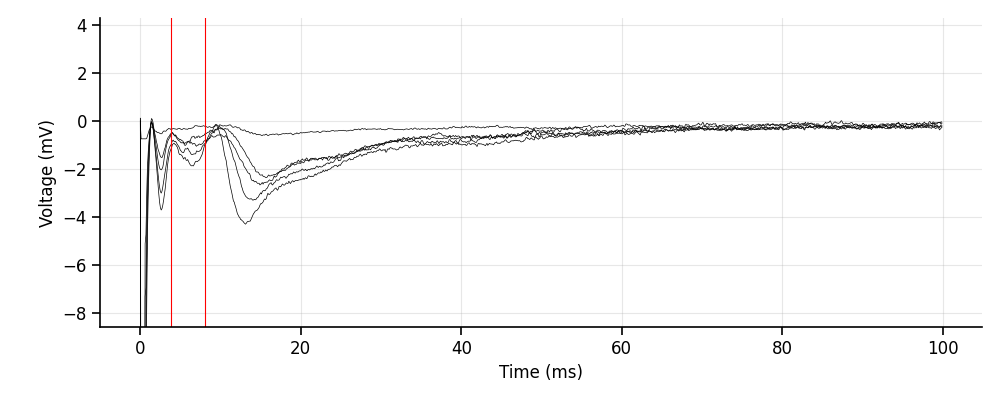

In [9]:
# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 3.8
marker_2 = 8

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
# %matplotlib inline
cropped_traces = traces.crop(timepoint=stim_times[0], window=100, time_units=time_units)
ax = cropped_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
_, min_voltages = cropped_traces.get_measurements(start_time=1, end_time=50, measurement_type='min', time_units=time_units)
ax.set_ylim(bottom=np.min(min_voltages)*2, top=-np.min(min_voltages))
plt.show()

Fiber volley amplitudes: [0.3559 1.018  1.0522 1.3993 1.874 ]


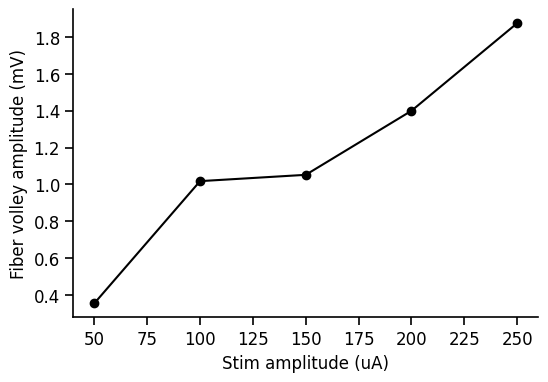

In [10]:
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

_, fiber_volley_amplitudes = cropped_traces.get_measurements(start_time=marker_1,
                                                            end_time=marker_2,
                                                            measurement_type=measurement_type,
                                                            time_units=time_units, sweep='all')
fiber_volley_amplitudes = np.abs(fiber_volley_amplitudes)
print(f"Fiber volley amplitudes: {fiber_volley_amplitudes}")

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(stim_amplitudes, fiber_volley_amplitudes, 'o-', color='k')
ax.set_xlabel('Stim amplitude (uA)')
ax.set_ylabel('Fiber volley amplitude (mV)')
plt.show()

## 3. Measure the field EPSP (fEPSP)

#### The peak of the fEPSP is not a realiable metric, because it is affected by the population spike.

#### Instead we will fit a line to the initial part of the fEPSP and measure the slope 

(stronger stim should result in faster rising EPSP and therefore a steeper slope)

First let's define the relevant time window where we want to fit, so we can fit a line to the rising phase

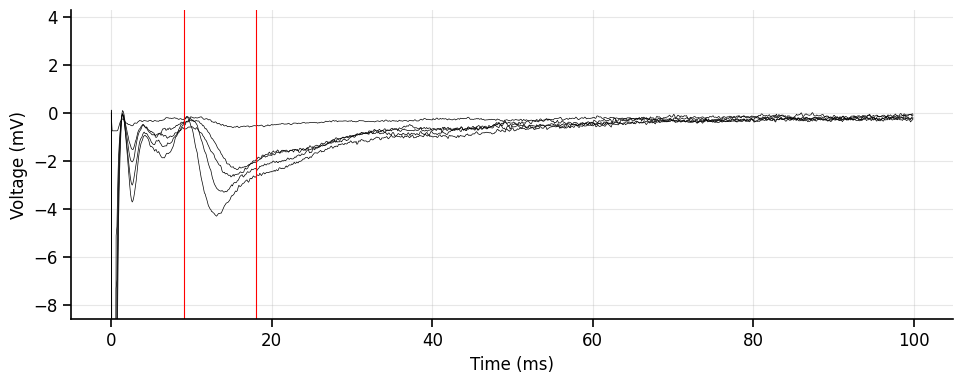

In [11]:
marker_3 = 9
marker_4 = 18

# ----------------------------------------------------------------------------------------------------------------------
# %matplotlib widget
%matplotlib inline
ax = cropped_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, marker_1=marker_3, marker_2=marker_4, sweep='all')
ax.set_ylim(bottom=np.min(min_voltages)*2, top=-np.min(min_voltages))
plt.show()

Now we will crop the traces around this window defined by the markers and fit lines to the initial phase of the fEPSP

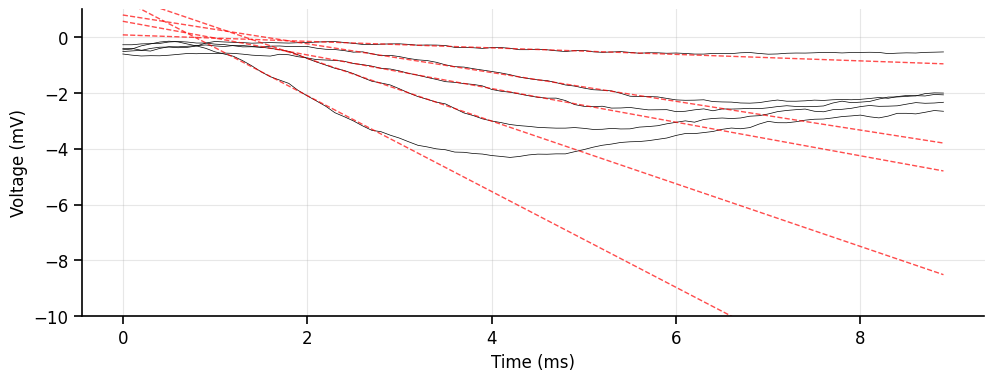

In [12]:
fEPSP_crop = cropped_traces.crop(timepoint=marker_3, timepoint_2=marker_4, time_units=time_units)

%matplotlib inline
ax = fEPSP_crop.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')

fEPSP_start = np.argmax(fEPSP_crop.voltage_data, axis=1)
fEPSP_end = np.argmin(fEPSP_crop.voltage_data, axis=1)

slopes = []
for i in range(fEPSP_crop.num_sweeps):
    trace = fEPSP_crop.voltage_data[i]
    
    # Get peak indices and values for this trace
    peak_start_idx = fEPSP_start[i]
    peak_end_idx = fEPSP_end[i]
    peak_start_val = trace[peak_start_idx]  # Upper peak value
    peak_end_val = trace[peak_end_idx]      # Lower peak value

    fit_start_idx = peak_start_idx + 12
    fit_end_idx = peak_end_idx - 12

    # Extract time and voltage for fitting region
    time_fit = fEPSP_crop.time_ms[fit_start_idx:fit_end_idx]
    voltage_fit = trace[fit_start_idx:fit_end_idx]
    
    # Fit linear regression
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_fit, voltage_fit)
    slopes.append(slope)
    
    # Plot fitted line on original time scale
    fit_line = slope * fEPSP_crop.time_ms + intercept
    ax.plot(fEPSP_crop.time_ms, fit_line, linestyle='--', color='r', alpha=0.7, linewidth=1)

slopes = np.array(slopes)
ax.set_ylim(-10,1)
plt.show()



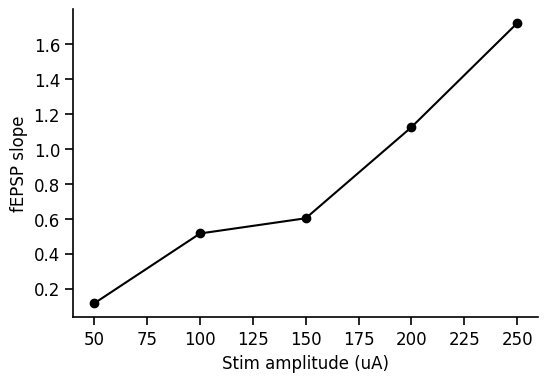

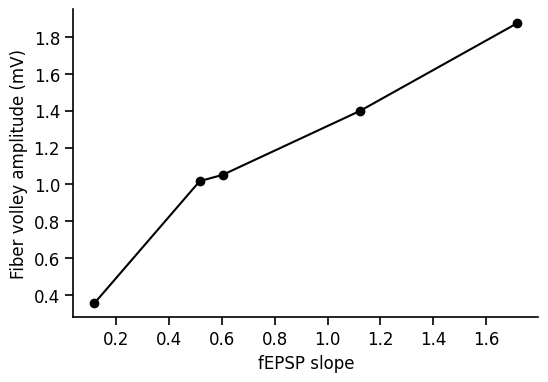

In [13]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(stim_amplitudes, -slopes, '-o', color='k')
ax.set_xlabel('Stim amplitude (uA)')
ax.set_ylabel('fEPSP slope')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(np.abs(slopes), fiber_volley_amplitudes, '-o', color='k')
ax.set_ylabel('Fiber volley amplitude (mV)')
ax.set_xlabel('fEPSP slope')
plt.show()